In [1]:
import datetime
import numpy as np
import pandas as pd
from yahoo_finance_api import YahooFinance as yf
import matplotlib.pyplot as plt

In [2]:
stock_symbol = 'TCS.NS'
my_stock = pd.DataFrame()
my_stock[stock_symbol+'_close'] = yf(ticker = stock_symbol, 
                            result_range='5d',
                            interval = '1m',
                            dropna = True).result['Close']

print('Shape of the dataframe: ', my_stock.shape)
my_stock.head()

/home/arjun/anaconda3/lib/python3.7/site-packages/yahoo_finance_api-0.0.1-py3.7.egg/yahoo_finance_api/__init__.py:73: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


Shape of the dataframe:  (1849, 1)


,TCS.NS_close
2020-10-08 09:15:00,2868.0
2020-10-08 09:16:00,2851.3
2020-10-08 09:17:00,2848.5
2020-10-08 09:18:00,2834.3
2020-10-08 09:19:00,2835.7


### Scaling the data

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(my_stock)
scaled_data

array([[0.8343887 ],
       [0.67169995],
       [0.6444228 ],
       ...,
       [0.27033609],
       [0.23867511],
       [0.26546517]])

* Creating a data structure with 60 timesteps and 1 output

In [5]:
X_train, y_train = [], []
time_step = 60
num_data_points = (len(scaled_data))
for i in range(time_step, num_data_points):
    X_train.append(scaled_data[i - time_step: i, 0])
    y_train.append(scaled_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
print('shape of training data before transformation: ', X_train.shape)
X_train = np.reshape(a = X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))
print('shape of training data after transformation: ', X_train.shape)

shape of training data before transformation:  (1789, 60)
shape of training data after transformation:  (1789, 60, 1)


### Building RNN model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [9]:
model = Sequential()

# first lstm layer followed by dropout
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(rate = 0.2))

# second lstm layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))

# third lstm layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))

# fourth lstm layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))

# output layer
model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            2

In [10]:
# compiling RNN
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [11]:
model.fit(x = X_train, 
          y = y_train , 
          epochs = 50, 
          batch_size = 32)

Epoch 1/50
56/56 [==============================] - 4s 63ms/step - loss: 0.0524
Epoch 2/50
56/56 [==============================] - 4s 63ms/step - loss: 0.0223
Epoch 3/50
56/56 [==============================] - 4s 63ms/step - loss: 0.0178
Epoch 4/50
56/56 [==============================] - 4s 64ms/step - loss: 0.0161
Epoch 5/50
56/56 [==============================] - 4s 63ms/step - loss: 0.0145
Epoch 6/50
56/56 [==============================] - 4s 65ms/step - loss: 0.0142
Epoch 7/50
56/56 [==============================] - 4s 64ms/step - loss: 0.0132
Epoch 8/50
56/56 [==============================] - 4s 64ms/step - loss: 0.0127
Epoch 9/50
56/56 [==============================] - 4s 65ms/step - loss: 0.0123
Epoch 10/50
56/56 [==============================] - 4s 71ms/step - loss: 0.0117
Epoch 11/50
56/56 [==============================] - 4s 71ms/step - loss: 0.0116
Epoch 12/50
56/56 [==============================] - 4s 72ms/step - loss: 0.0116
Epoch 13/50
56/56 [==================

In [12]:
X_test = scaled_data[-12:,0]

In [14]:
print('Shape of X_test before transformation: ', X_test.shape)
X_test = np.reshape(X_test, newshape = (1, X_test.shape[0],1))
print('Shape of X_test after transformation: ', X_test.shape)

Shape of X_test before transformation:  (12,)
Shape of X_test after transformation:  (1, 12, 1)


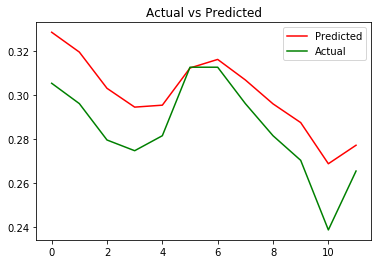

In [17]:
plt.plot(np.hstack(model.predict(X_test)), color = 'red')
plt.plot(np.hstack(X_test), color = 'green')
plt.legend(['Predicted', 'Actual'])
plt.title('Actual vs Predicted')
plt.show()